In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# Map the problem to a quantum circuit

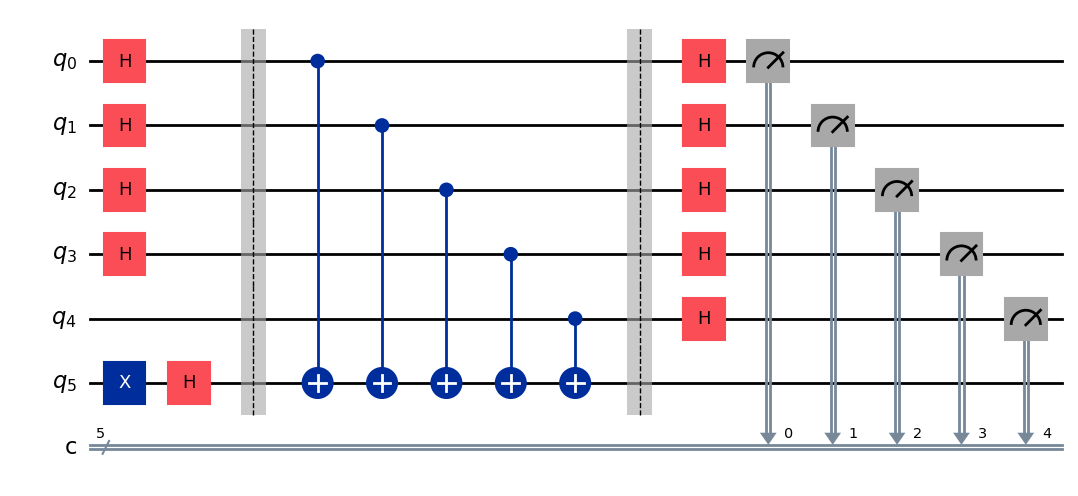

In [61]:
from qiskit import QuantumCircuit
from random import randint
n = 5 # number of bits
qc = QuantumCircuit(n+1, n) # circuit init with an extra Auxiliary qubit

# initialise Oracle

for i in range(0, n-1):
    qc.h(i)

def oracle(circuit, n):
    hidden_bits = randint(0,2**n-1) # random n-digit number
    hidden_bits = format(hidden_bits,'0'+str(n)+'b') # binary convert
    circuit.barrier()
    for i in range(n):
        if hidden_bits[i] == 0:
            pass
        elif hidden_bits[1] == '1':
            circuit.cx(i, n)
    circuit.barrier()
    
    return circuit, hidden_bits

qc.x(n)
qc.h(n)

circuit, hidden_bits = oracle(qc, n)

for i in range(n):
    circuit.h(i)
    circuit.measure(i, i)

circuit.draw(output="mpl")

In [77]:
from qiskit.quantum_info import SparsePauliOp
 
# ZZII...II, ZIZI...II, ... , ZIII...IZ
 
operators = SparsePauliOp.from_sparse_list([("ZX", [1, 4], 1), ("YY", [0, 3], 2)], num_qubits=n+1)

# Optimize the problem for execution on quantum hardware

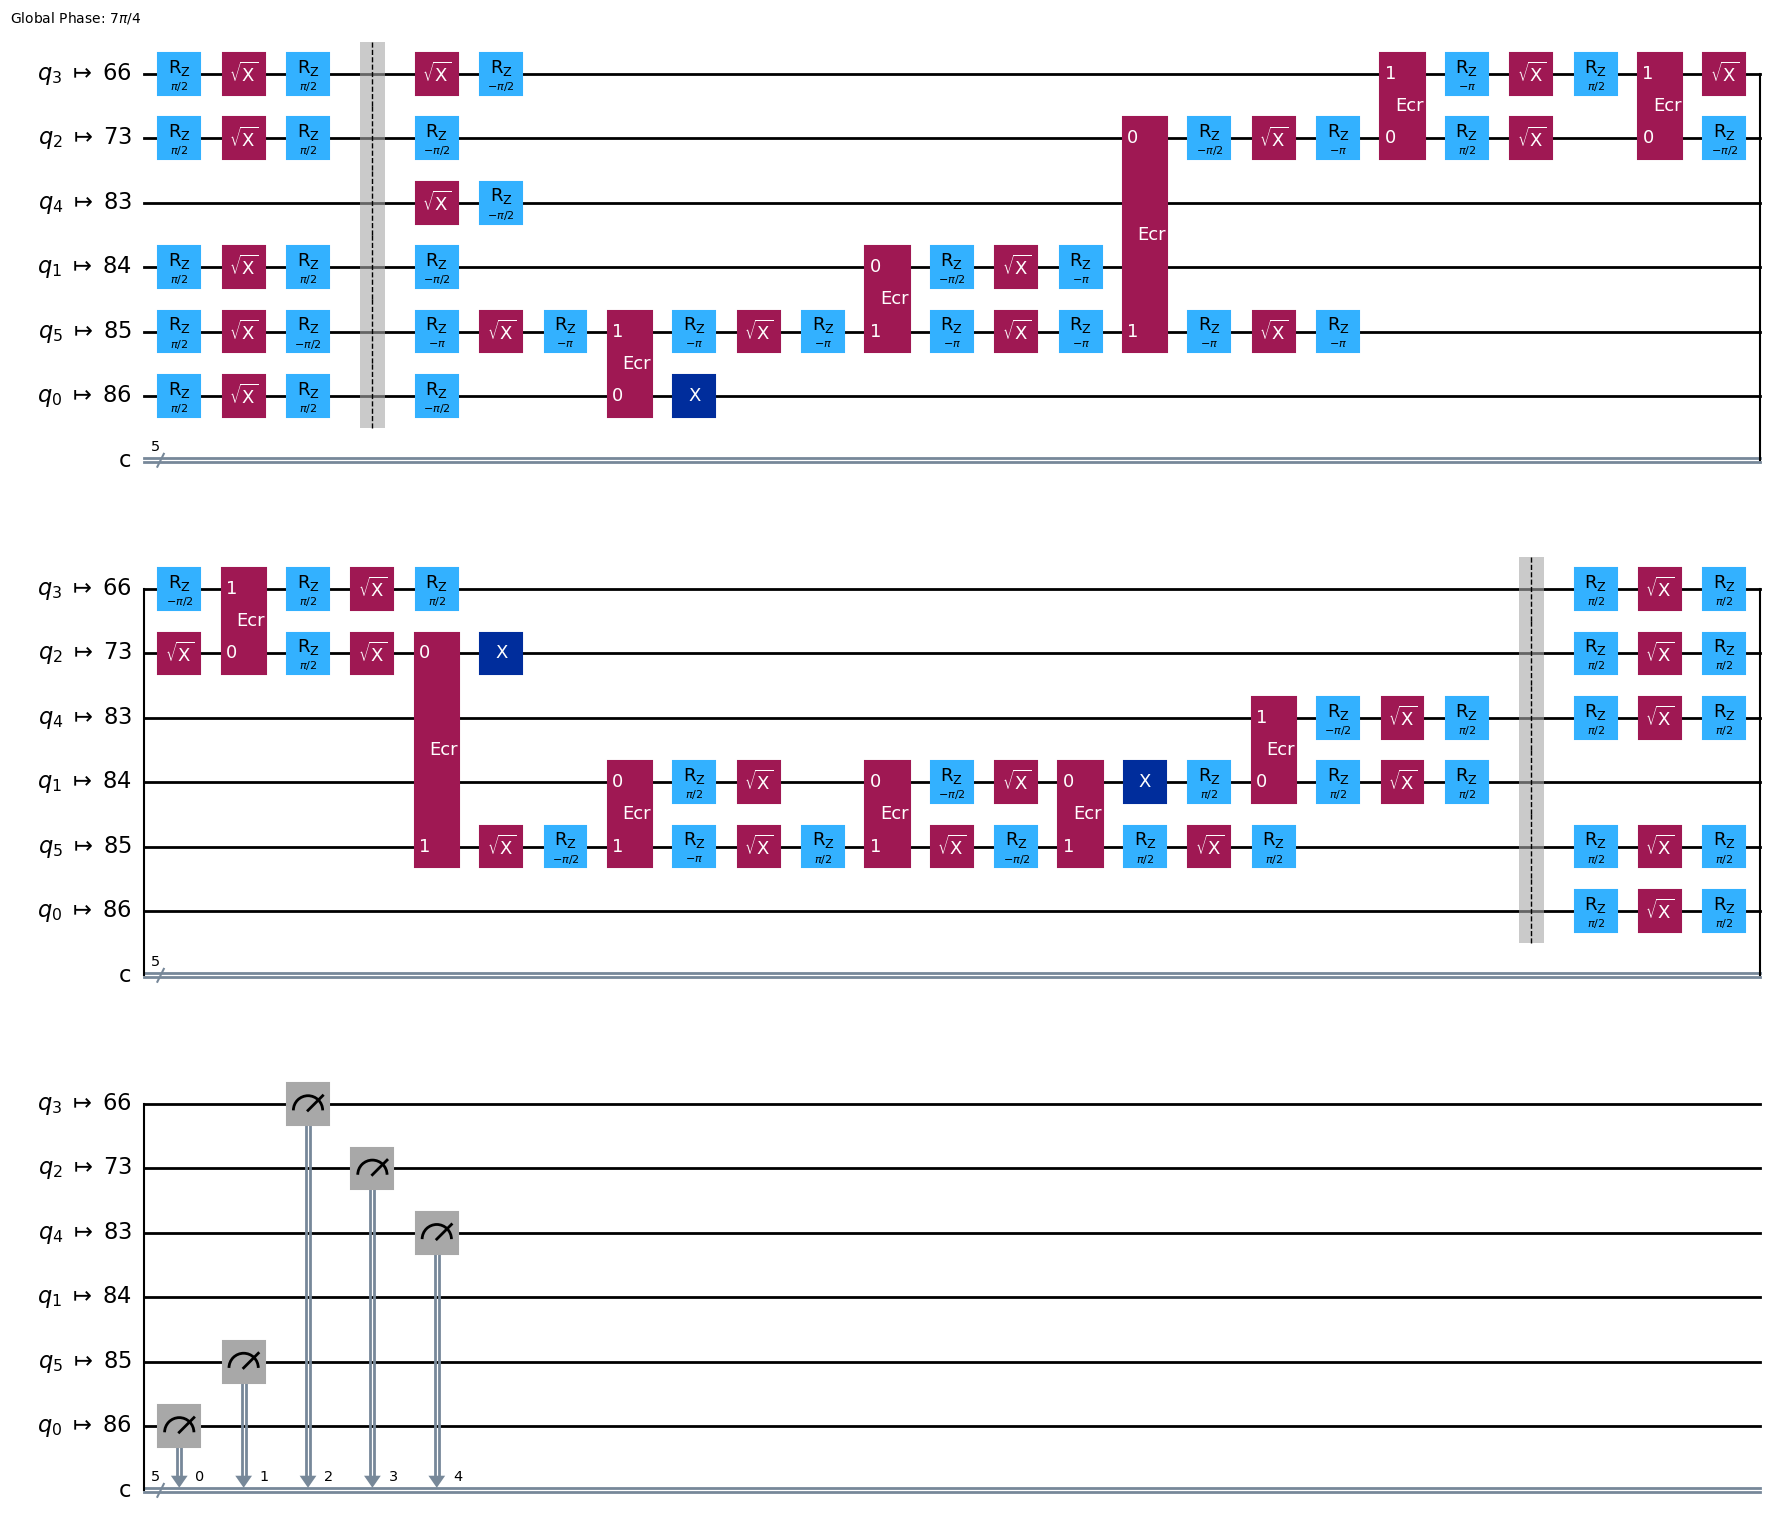

In [78]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit = pm.run(circuit)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

isa_circuit.draw('mpl', idle_wires=False)

In [79]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
 
# Create an Estimator object
estimator = Estimator(backend, options=options)

In [82]:
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

csywsmejyjyg008s5ypg


In [90]:
result = job.result()